<a href="https://colab.research.google.com/github/Juniormoraess/Machine-Learning/blob/master/Projeto_Sars-Cov-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparação entre modelos de classificação para Sars-Cov-2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, learning_curve, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funções principais

In [ ]:
def accuracy (y, y_pred):
    count = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
             count += 1 
 
    return count / len(y)
    
def recall (y, y_pred):
    tp, fn = 0, 0
    
    for i in range(len(y)):
        if(y[i] == y_pred[i]):
            tp += 1
        else:
            fn += 1
    
    return tp / (tp + fn)
 
def precision (y, y_pred):
    tp, fp = 0, 0
    
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            tp += 1
        elif y[i] == 1 and y_pred[i] == 0:
            fp += 1
    
    return tp / (tp + fp)
 
def F1 (y, y_pred):
    tp, fp, fn = 0, 0, 0
    
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            tp += 1
        elif y[i] == 1 and y_pred[i] == 0:
            fp += 1
        else:
            fn += 1
            
    return tp / (tp + 0.5 * (fp + fn))

In [ ]:
def compute_metrics(y, y_pred):
    metrics = {
        'Acurácia': accuracy_score(y, y_pred), 
        'Precisão': precision_score(y, y_pred), 
        'Recall': recall_score(y, y_pred), 
        'F1-Score': f1_score(y, y_pred)
    }

    return pd.DataFrame(pd.Series(metrics))

In [ ]:
class LogisticReg:
    def __init__(self, n_iter=200):
        self.n_iter = n_iter

    def fit(self, X_train, y_train, params, cv):
        self.estimator = LogisticRegression(max_iter=self.n_iter)
        gs = GridSearchCV(estimator=self.estimator, param_grid=params, cv=cv)
        gs.fit(X_train, y_train)
        self.best_params = gs.best_params_

        self.estimator = LogisticRegression(max_iter=self.n_iter, **self.best_params)
        self.estimator.fit(X_train, y_train)
    
    def predict(self, X_test):
        pred = self.estimator.predict(X_test)
        self.best_estimator = self.estimator
        return pred

    def calc_metrics(self, y_test, pred):
        self.metrics = compute_metrics(y_test, pred)
        self.metrics.rename(columns={0: 'Reg. Log.'})

    def plot_metrics(self):
        plt.title('Métricas do Modelo')
        self.metrics.rename(columns={0: 'Reg. Log.'})
        sns.barplot(x=self.metrics.index.to_list(), y=self.metrics[0])
        plt.show()

In [ ]:
class SVM:
    def __init__(self, n_iter=200):
        self.n_iter = n_iter

    def fit(self, X_train, y_train, params, cv):
        self.estimator = SVC(kernel='rbf', max_iter=self.n_iter)
        gs = GridSearchCV(self.estimator, param_grid=params, cv=cv)
        gs.fit(X_train, y_train)
        self.best_params = gs.best_params_

        self.estimator = SVC(kernel='rbf', max_iter=self.n_iter, **self.best_params)
        self.estimator.fit(X_train, y_train)

    def predict(self, X_test):
        pred = self.estimator.predict(X_test)
        self.best_estimator = self.estimator
        return pred
    
    def calc_metrics(self, y_test, pred):
        self.metrics = compute_metrics(y_test, pred)
        self.metrics.rename(columns={0: 'SVM'})

    def plot_metrics(self):
        plt.title('Métricas do Modelo')
        self.metrics.rename(columns={0: 'SVM'})
        sns.barplot(x=self.metrics.index.to_list(), y=self.metrics[0])
        plt.show()

In [ ]:
class MLP:
    def __init__(self, n_iter=200):
        self.n_iter = n_iter

    def fit(self, X_train, y_train, params, cv):
        self.estimator = MLPClassifier(solver='sgd', max_iter=self.n_iter, verbose=2)

        gs = GridSearchCV(estimator=self.estimator, param_grid=params, cv=cv)
        gs.fit(X_train, y_train)
        self.best_params = gs.best_params_

        self.estimator = MLPClassifier(solver='sgd', max_iter=self.n_iter, **self.best_params)
        self.estimator.fit(X_train, y_train)

    def predict(self, X_test):
        pred = self.estimator.predict(X_test)
        self.best_estimator = self.estimator
        return pred

    def calc_metrics(self, y_test, pred):
        self.metrics = compute_metrics(y_test, pred)
        self.metrics.rename(columns={0: 'MLP'})

    def plot_metrics(self):
        plt.title('Métricas do Modelo')
        self.metrics.rename(columns={0: 'MLP'})
        sns.barplot(x=self.metrics.index.to_list(), y=self.metrics[0])
        plt.show()

## Carregando a base de dados

In [ ]:
cols = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/srag_cov_columns.csv', delimiter=';')
columns = cols['Colunas CLASS'].dropna().tolist()

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/srag_cov_class.csv', sep=',', usecols=columns)

In [ ]:
def binary(data):
    if data == 5:
        return 0
    else :
        return 1

y = dataset['CLASSI_FIN'].apply(binary).to_numpy()
X = dataset.drop('CLASSI_FIN', axis=1).to_numpy()

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

skf = KFold(n_splits=5)

## Treinando a Regressão Logística

In [ ]:
params_lr = {'C': [1, 10, 100, 1000, 10000]}
log_reg = LogisticReg(n_iter=200)
log_reg.fit(X_train, y_train, params_lr, skf)
pred_lr = log_reg.predict(X_test)

### Métricas e melhores parâmetros

Melhores parâmetros: {'C': 10000}

Métricas:
Acurácia    0.893810
Precisão    0.793740
Recall      0.826014
F1-Score    0.809555
Name: 0, dtype: float64


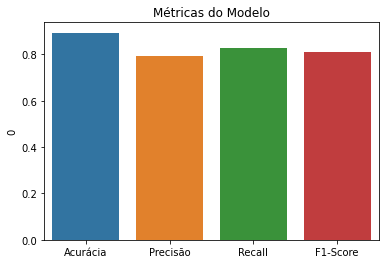

In [ ]:
print(f'Melhores parâmetros: {log_reg.best_params}')
print('\nMétricas:')
metrics_lr = log_reg.calc_metrics(y_test, pred_lr)
print(log_reg.metrics[0])
log_reg.plot_metrics()

## Treinando o SVM

In [ ]:
gamma_range = np.array((2e-3, 2e-1, 2e1))
c_range = np.array((2e-3, 2e-1, 2e1))
 
params_svm = dict(gamma=gamma_range, C=c_range)
it = 2000
svm = SVM(n_iter=it)
svm.fit(X_train, y_train, params_svm, skf)
pred_svm = svm.predict(X_test)

### Métricas e melhores parâmetros

Melhores parâmetros: {'C': 20.0, 'gamma': 0.2}

Métricas:
Acurácia    0.786500
Precisão    0.593750
Recall      0.702806
F1-Score    0.643692
Name: 0, dtype: float64


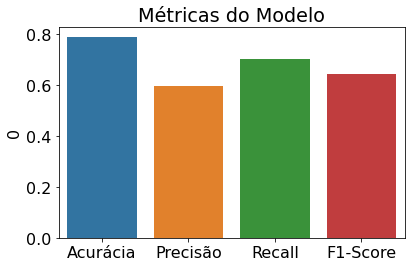

In [ ]:
print(f'Melhores parâmetros: {svm.best_params}')
print('\nMétricas:')
metrics_svm = svm.calc_metrics(y_test, pred_svm)
print(svm.metrics[0])
svm.plot_metrics()

### Treinando a Rede Neural

In [ ]:
params_mlp = {'hidden_layer_sizes': [4, 16, 32], 
              'batch_size': [8, 16, 32]
              }
 
mlp = MLP(n_iter=3)
mlp.fit(X_train, y_train, params_mlp, skf)
pred_mlp = mlp.predict(X_test)

Melhores parâmetros: {'batch_size': 8, 'hidden_layer_sizes': 32}

Métricas:
               MLP
Acurácia  0.938134
Precisão  0.850173
Recall    0.940848
F1-Score  0.893215


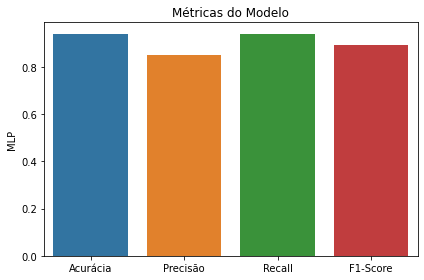

In [ ]:
pred_mlp = mlp.predict(X_test)
print(f'Melhores parâmetros: {mlp.best_params}')
print('\nMétricas:')
metrics_mlp = compute_metrics(y_test, pred_mlp)
metrics_mlp.rename(columns={0: 'MLP'}, inplace=True)
print(metrics_mlp)
 
plt.title('Métricas do Modelo')
sns.barplot(x=metrics_mlp.index.to_list(), y=metrics_mlp['MLP'])
plt.show()

## Tabela de Métricas

In [ ]:
df = pd.DataFrame(pd.Series(metrics_lr))
df['SVM'] = metrics_svm.values()
df['MLP'] = metrics_mlp.values()
df.rename(columns={0: 'Reg. Logística'})

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
 
# Matplolib defaults
figsize = (8,6)
fontsize = 20
markersize = 12
linewidth = 2
dpi = 300
plt.rcParams.update({'figure.autolayout': True})
 
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
 
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)
 
    print(cm)
 
    plt.rcParams.update({'font.size': 16})
    fig, ax = plt.subplots(figsize=figsize)    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
 
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    fig.tight_layout()
    
    return ax

Matriz de Confusão (RNA)
[[184677  12395]
 [  4422  70334]]


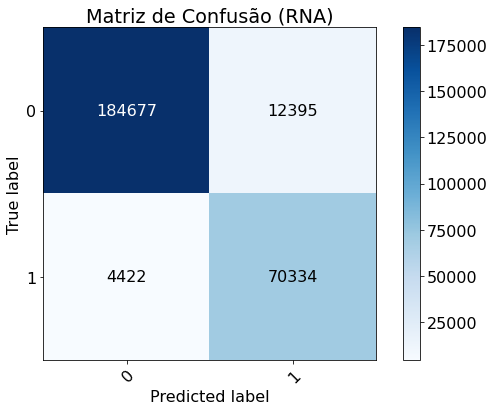

In [ ]:
plot_confusion_matrix(y_test.astype('int'), y_pred=pred_mlp.astype('int'), classes=mlp.best_estimator.classes_.astype('int'), title="Matriz de Confusão (RNA)")
plt.savefig('confusion_matrix_mlp')

Matriz de Confusão (Regressão Logística)
[[181391  15681]
 [ 13058  61698]]


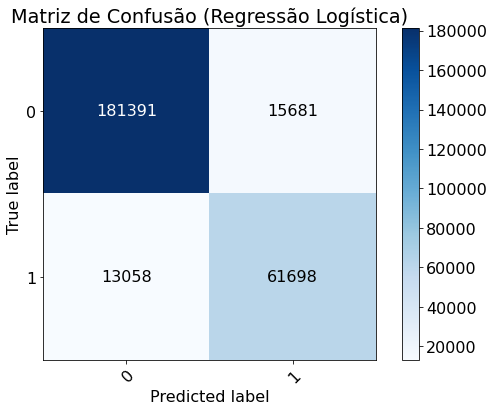

In [ ]:
plot_confusion_matrix(y_test.astype('int'), y_pred=pred_lr.astype('int'), classes=log_reg.best_estimator.classes_.astype('int'), title="Matriz de Confusão (Regressão Logística)")
plt.savefig('confusion_matrix_rl')

Matriz de Confusão (SVM)
[[11873  2639]
 [ 1631  3857]]


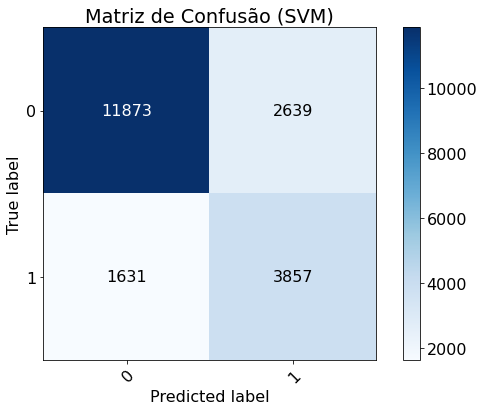

In [ ]:
plot_confusion_matrix(y_test.astype('int'), y_pred=pred_svm.astype('int'), classes=svm.best_estimator.classes_.astype('int'), title="Matriz de Confusão (SVM)")
plt.savefig('confusion_matrix_svm')

In [ ]:
len(np.where(y_test == 1)[0])

74756

In [ ]:
dataset.shape

(1359139, 79)